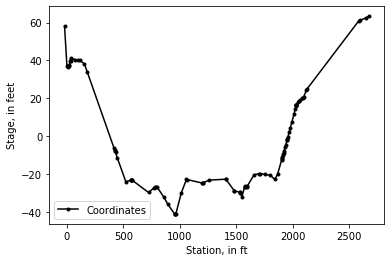

In [1]:
%matplotlib inline

import numpy as np

from anchovy.crosssection import CrossSection

from dynrat.sect import CrossSect


roughness = 0.035
station, elevation = np.loadtxt('data/stlms/xs.csv', delimiter=',', skiprows=1, unpack=True)
datum = 379.58
elevation = elevation - datum
sect = CrossSect(CrossSection(station, elevation, roughness))

_ = sect.plot()

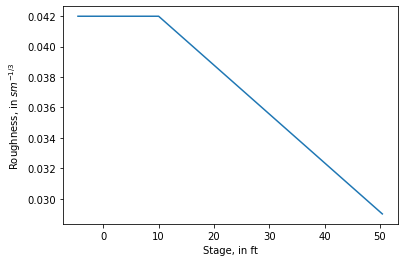

In [2]:
import matplotlib.pyplot as plt

from dynrat.frict import TableFrict


stage = np.array([-4.58, 10, 50.42])
roughness = [0.042, 0.042, 0.029]

frict = TableFrict(stage, roughness)

_ = frict.plot()

In [3]:
from dynrat.rslope import r_slope


h_o = 4.68  # stage prior to start of typical flood
h_p = 24.18  # peak stage of typical flood
q_o = 129000  # flow prior to typical flood
q_p = 396000  # peak flow of typical flood
t_diff = 7.58  # elapsed time of stage rise to peak stage in days

bed_slope = 0.00011

slope_ratio = r_slope(h_o, h_p, q_o, q_p, bed_slope, sect, t_diff)
slope_ratio

20.57614272438509

In [4]:
from dynrat.dynmod import QSolve


time_step = 60*60

q_solve = QSolve(sect, frict, bed_slope, slope_ratio, time_step)

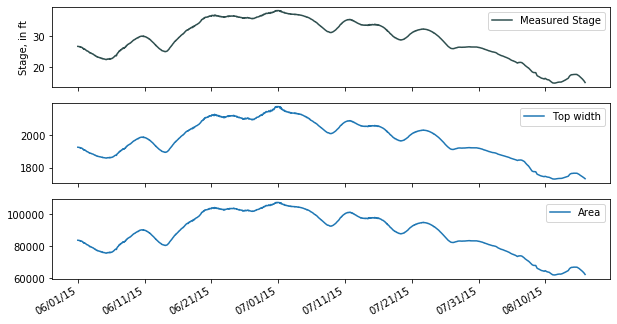

In [5]:
import pandas as pd

from dynrat.timeseries import MeasuredStageTimeSeries, RatedDischargeTimeSeries


qh_data = pd.read_csv('data/stlms/qh.csv', index_col=0, parse_dates=True)

stage_timeseries = MeasuredStageTimeSeries(qh_data['h'], freq=60*60, interp_missing=True)
rated_q_timeseries = RatedDischargeTimeSeries(qh_data['Q_rated'], freq=60*60)

fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, sharex=True, figsize=(10, 5))

_ = stage_timeseries.plot(ax1)
_ = stage_timeseries.cross_section_plot(sect, 'top width', ax2)
_ = stage_timeseries.cross_section_plot(sect, 'area', ax3)

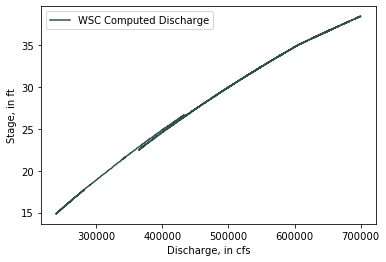

In [6]:
from dynrat.plot import stage_discharge_plot


_ = stage_discharge_plot(stage_timeseries, rated_q_timeseries)

In [7]:
from dynrat.solve import QTimeSeries


q0 = qh_data.values[0, 1]

qts = QTimeSeries(q_solve)
computed_q_timeseries = qts.solve_ts(stage_timeseries, q0)

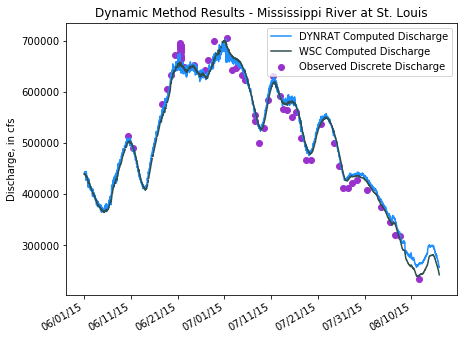

In [8]:
from dynrat.timeseries import ObservedDischargeTimeSeries


q_obs = pd.read_csv('data/stlms/qobs.csv', index_col=0, parse_dates=True)
q_fm = ObservedDischargeTimeSeries(q_obs['Q_obs'])

_ = plt.figure(figsize=(7,5))
ax = plt.gca()

_ = computed_q_timeseries.plot(ax)
_ = rated_q_timeseries.plot(ax)
_ = q_fm.plot(ax)

_ = ax.set_title('Dynamic Method Results - Mississippi River at St. Louis')

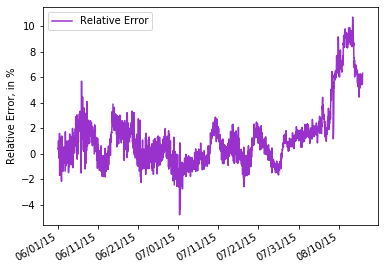

In [9]:
_ = computed_q_timeseries.plot_relative_error(rated_q_timeseries)

In [10]:
computed_q_timeseries.rmse(rated_q_timeseries)

8963.751666241673

In [11]:
computed_q_timeseries.mean_error(rated_q_timeseries, relative=True)

1.2876588732415133